# Weak learning models over synthetic datasets

    Notebook version: 1.0 (Mar 24, 2021)

    Author: Jesús Cid Sueiro (jcid@tsc.uc3m.es)
            Daniel Bacaicoa Barber 

    Changes: v.1.0 - First version.

In [1]:
# To visualize plots in the notebook
%matplotlib inline 
import matplotlib.pyplot as plt

# Import some libraries that will be necessary for working with data
import copy
import numpy as np
from collections import Counter
from sklearn.datasets import make_blobs, make_classification, load_wine

# Local imports
import weaklabels.WLweakener as wlw
import weaklabels.WLclassifier as wl_classifier
from drawers import plot_simplices
# import plot_simplices


## 1. Introduction.

In this notebook we analyze the behavior of weak label learning algorithms over synthetic datasets.

The main goal is to compare the behavior of a "supervised" estimate, based on a set of clean labels $\{{\bf y}_k, k=0,\ldots, K-1\}$, and estimates based on weak labels, $\{{\bf b}_k, k=0,\ldots, K-1\}$, generated from some related distribution ${\bf p} = {\bf M}\boldsymbol{\eta}$, where ${\bf M}$ is a transition matrix.

First we define some configurable parameters:

In [2]:
# CONFIGURABLE PARAMETERS FOR THE WHOLE NOTEBOOK

# ##############
# TRUE POSTERIOR

# Parameters for gaussian mixtures (only for blobs and sfm_unif)
sigma = 0.1    # Noise variance
alpha_priors = 10

# #######
# DATASET

# Number of classes
C = 3
# Sample sizes
n_train = 500
n_test = 10000
# Data dimension
D = 2   # int(n_samples/100)

# Dataset (blobs, or sfm_unif)
dataset = 'sfm_unif'

# ################
# WEAK LABEL MODEL

# Weak Label model. Used to generate the mixing matrix.
# Available options are: quasi_IPL, noisy, random_noise ...
wl_model = 'random_weak'# 'quasi-IPL'#'random_weak'   # 'quasi-IPL'    # 'random_noise'   # 'noisy', 'quasi_IPL'
alpha_M = 0.998
beta_M = [1,1,1,1,1,1,1,1]
#beta_M = [3,0.1,0.1,3,0.1,3,3,3]

# ###########################
# DEFAULT LEARNING ALGORITHM

# Virtual label model
vlm0 = 'M-opt-conv'
# Weight regularization
alpha = 0
# Optimization algorithm
optim = 'BFGS'      #   {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}   # newton-cg’,
# Loss and parameters
loss0 = 'LBL'
# k = 0.1
k = 0.0001
beta = 5
# Parameters for gradient descent (I guess they are used for optim='GD' only)
n_it = 500
rho = 0.01

# ###################
# LEARNING ALGORITHMS

# Algorithm specification: each dictionary entry specifies an algorithm to be tested.
alg_spec0 = {
    'M-pinv':     {'vl': 'M-pinv',     'loss': 'LBL'},
    'M-conv':     {'vl': 'M-conv',     'loss': 'LBL'},
    'M-opt':      {'vl': 'M-opt',      'loss': 'LBL'},
    'M-opt-conv': {'vl': 'M-opt-conv', 'loss': 'LBL'},
    'S-LBL':      {'vl': 'Supervised', 'loss': 'LBL'},
    'S_CE':       {'vl': 'Supervised', 'loss': 'CE'}}
vlm0 = 'M-opt-conv'
alg_spec1 = {
    'oc_k1': {'vl': vlm0, 'loss': 'LBL', 'k': 0.00001},
    'oc_k2': {'vl': vlm0, 'loss': 'LBL', 'k': 0.0001},
    'oc_k3': {'vl': vlm0, 'loss': 'LBL', 'k': 0.001},
    'oc_k4': {'vl': vlm0, 'loss': 'LBL', 'k': 0.01},
    'oc_k5': {'vl': vlm0, 'loss': 'LBL', 'k': 0.1},
    'oc_k6': {'vl': vlm0, 'loss': 'LBL', 'k': 1}}
alg_spec2 = {
    'ocB1': {'vl': vlm0, 'loss': 'LBL', 'beta': 1.5},
    'ocB2': {'vl': vlm0, 'loss': 'LBL', 'beta': 2},
    'ocB3': {'vl': vlm0, 'loss': 'LBL', 'beta': 3},
    'ocB4': {'vl': vlm0, 'loss': 'LBL', 'beta': 5},
    'ocB5': {'vl': vlm0, 'loss': 'LBL', 'beta': 6},
    'ocB6': {'vl': vlm0, 'loss': 'LBL', 'beta': 7}}
alg_spec = alg_spec0

# #####
# SEEDS

seed_p = 0
seed_w = 0
seed_x = 1
seed_M = 5

In [3]:
# Default parameters 
params_default = {'loss': 'LBL', 'n_it': n_it, 'rho': rho, 'k': k, 'beta': beta, 'alpha': alpha}

# Buid dictionary of learning algorithms
algorithms = {}
for name, alg in alg_spec.items():
    algorithms[name] = {}
    algorithms[name]['vl'] = alg['vl']
    algorithms[name]['params'] = copy.copy(params_default)
    for k in alg:
        if k != 'vl':
            algorithms[name]['params'][k] = alg[k]

The following methods will be useful to compute predictions and make model evaluations.

In [4]:
def normalize_rows(W):
    """
    Centers the row vectors (this helps to avoid saturation of exponentials)
    If W is the input matrix, the normalized matrix Wn satisfies:
        Wn·1 = 0
        softmax(X·W) = softmax(X·Wn)
    (for any X where 1 is a vector of ones)
    
    Parameters
    ----------
    W: numpy.ndarray (n_samples x n_classes)
        Input weight matrix
    
    Returns
    -------
    numpy.ndarray (n_samples x n_classes)
        Normalized weights
    """
    return W - np.mean(W, axis=1, keepdims=True)
    

def log_predict(X, W):
    """
    Compute the logarithmic predictions for inputs X given a softmax model
    with parameters W
    
    Parameters
    ----------
    X: numpy array
        Input data: a matrix with dimension (n_samples x n_features)
    W: numpy arra
        Model parameters: a matrix with dimension (n_features x n_classes)
    
    Returns
    -------
    log_pred: numpy.ndarray (n_samples x n_classes)
        Matrix of log-probabilistic predictions    
    """

    # Linear scores (n_samples x n_classes)
    S = X @ W
    # This is just to reduce the possibility of saturating exponentials
    S = normalize_rows(S)
    
    # Sums of log-scores
    z = np.log(np.sum(np.exp(S), axis=1, keepdims=True))
    log_pred = S - z

    return log_pred

def predict_proba(X, W):
    """
    Compute the probabilistic predictions for inputs X given a softmax model
    with parameters W
    
    Parameters
    ----------
    X: numpy array
        Input data: a matrix with dimension (n_samples x n_features)
    W: numpy arra
        Model parameters: a matrix with dimension (n_features x n_classes)
    
    Returns
    -------
    numpy.ndarray (n_samples x n_classes)
        Matrix of probabilistic predictions    
    """
    # Compute a prediction
    return np.exp(log_predict(X, W))

def KLdiv(P, Q):
    """
    Computes the KL divergence between the probaility distributions in matrices P and Q
    
    Parameters
    ----------
    P: numpy.ndarray (n_samples x n_classes)
        A matrix of discrete probability distributions
    Q: numpy.ndarray (n_samples x n_classes)
        A matrix of discrete probability distributions
        
    Returns
    -------
    KLdiv: numpy.ndarray (n_samples,)
        KL divergence between co-located pairs of probability distributions in P and Q.
        (KLdiv[i] contains the divergence between distributions P[i] and Q[i])
    """
    KLdiv = np.sum(P * (np.log(P) - np.log(Q)), axis=1)    
    return KLdiv


def KLdiv_from_weights(W, V, X):
    """
    Computes the KL divergence between the probabilistic predictions based on two different softmax
    models.    
    It is equivalent to 
        (1) Compute probabilistic predicions P and Q for softmax models W and V, resp., and
        (2) compute the KL div between P and Q. 
    The computation of P and Q is avoided for higher precision
    """
    KLdiv = np.sum(predict_proba(X, W) * (log_predict(X, W) - log_predict(X, V)), axis=1)    
    return KLdiv

def sparsemax(Z):
    """
    Computes the sparsemax projection of the probability values.
    The code is an adaptation of a version taken from
    https://towardsdatascience.com/what-is-sparsemax-f84c136624e4
    
    Parameters
    ----------
    Z : numpy.ndarray (n_samples x n_classes)
        Input data. Each row is a vector to be projected.

    Parameters
    ----------
    Y : numpy.ndarray (n_samples x n_classes)
        Proyections.    
    """
    
    k = np.arange(Z.shape[1])
    Z_sorted = -np.sort(-Z, axis=1)
    K_array = 1 + k * Z_sorted
    Z_cumsum = np.cumsum(Z_sorted, axis=1) - Z_sorted
    K_selected = K_array > Z_cumsum

    for i in range(Z.shape[0]):
        k_max = np.where(K_selected[i])[0].max() + 1
        if k_max < Z.shape[1]:
            threshold = (Z_cumsum[i, k_max] - 1) / k_max
        else:
            threshold = (np.sum(Z[i]) - 1) / k_max
        yi = np.maximum(Z[[i], :] - threshold, 0)
        if i == 0:
            Y = copy.copy(yi)
        else:
            Y = np.vstack((Y, yi))

    return Y

## 2. Model

### 2.1. Model generation

First, we will generate a logistic regresion model. 

Instead of generating model weights directly at random, we compute the model weight from a randomly generated gaussian mixture model.

In [5]:
# ##############
# Generate model

# Set the random number generator
np.random.seed(seed_p)

# Gaussian-like parameters (they are used to compute reasonable weights,
# even though the input distribution might not be a Gaussian mixture)
centers = np.random.rand(C, D)
# Priors
priors = np.random.dirichlet(alpha_priors * np.ones(C))

# True weighs of the logistic regression model
W = centers.T / sigma**2
w0 = - np.sum(centers**2, axis=1, keepdims=True).T / (2 * sigma**2) + np.log(priors)

# Weight matrix of the softmax model
true_W = np.vstack((w0, W))
# Normalize the weight matrix of the softmax model (it does not change the posteriors)
true_W = normalize_rows(true_W)

### 2.2. Dataset generation

Given the posterior probability model, we generate the dataset, in two possible ways:

  * Dataset **blobs**: Samples are generated according to the gaussian mixture model used to define the posterior probability model. 
  * Dataset **sfm_uni**: Samples are generated according to a uniform distribution.

In [6]:
# #################
# Generate dataset

# Set the random number generator
np.random.seed(seed_x)

# This is to add the bias term to features
n_samples = n_train + n_test
col_ones = np.ones((n_samples, 1))

# Generate the selected dataset
if dataset == 'blobs':
    samples_per_class = np.random.multinomial(n_samples, priors)

    # Generate data
    X, y = make_blobs(n_samples=samples_per_class, cluster_std=sigma, centers=centers,
                      n_features=D)
    # Add column with one's
    Xe = np.hstack((col_ones, X))

    # True posteriors
    posteriors = predict_proba(Xe, true_W)
        
elif dataset == 'sfm_unif': 

    X = np.random.rand(n_samples, D)
    y = np.zeros(n_samples, dtype=int)

    # Add column with one's
    Xe = np.hstack((col_ones, X))

    # True posteriors
    posteriors = predict_proba(Xe, true_W)
    
    # Generate labels from posteriors
    for i, x in enumerate(Xe):
        y[i] = np.random.choice(C, size=None, p=posteriors[i])        

    print(f'true_W = {true_W}')

true_W = [[ -5.94663544   1.33682027   4.60981517]
 [  2.37362775   7.76861496 -10.14224271]
 [  7.98671456  -9.04390378   1.05718923]]


Now we show the scatter plot of the first 2 dimensions.

[0.21818492 0.42230484 0.35951024]
Class proportions: [0.21818492 0.42230484 0.35951024]


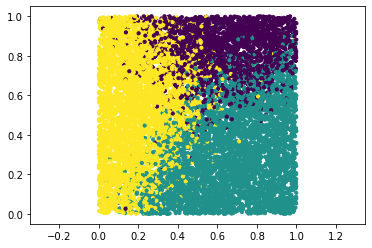

In [7]:
# Compute class proportions
bin_y = np.eye(C)[y]    # Binarize classes
# Compute class proportions
# eta = np.mean(bin_y, axis=0)
eta = np.mean(posteriors, axis=0)
print(eta)
# Compare priors and proportions:
print(f'Class proportions: {eta}')

plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=10)
plt.axis('equal')
plt.show()

Now we can make the train/test partition.

### 2.3. Weak label model

#### 2.3.1. Mixing matrix

Based on the selected weak label model, we generate and visualize the corresponding mixing matrix.

Weak classes: [0 1 2 3 4 5 6 7]


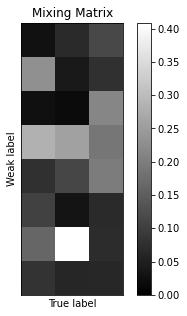

In [8]:
# Set the random number generator
np.random.seed(seed_M)

# Create a weak label model object
WLM = wlw.WLmodel(C, model_class=wl_model)

# Generate a mixing matrix
M = WLM.generateM(alpha=alpha_M, beta=beta_M)
n_weak = M.shape[0]      # Number of weak categories
# Remove weak classes with zero probability
WLM.remove_zero_rows()
M = WLM.M                # This is just to abbreviate

print(f"Weak classes: {WLM.weak_classes}")

# Show mixing matrix
if n_weak < 5:
    print("Mixing matrix:")
    print(M)
    print(f"Corresponding to weak label indices {dec_labels}")

plt.figure(figsize=(5, 5))
plt.imshow(M, interpolation='nearest', cmap="gray", clim=(0.0, np.max(M))) 
plt.colorbar()
plt.title('Mixing Matrix')
plt.xlabel('True label')
plt.ylabel('Weak label')
plt.xticks([], [])
plt.yticks([], [])
plt.show()

#### 2.2.2. Weak label priors

In the following we analyze the sparsity of the weak label priors by showing the values of the prior weak label probabilities in increasing order.

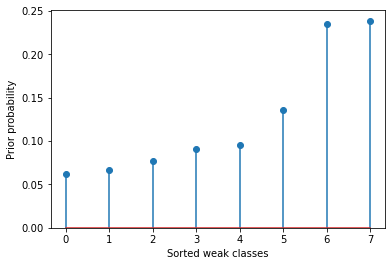

The entropy is 1.9442676427673646 (maximum is 2.0794415416798357)
The minimum weak class probability is 0.06145643714189422


In [9]:
# Weak label priors
p = M @ eta
h = - p @ np.log(p).T

# plt.plot(np.sort(p),'.')
plt.stem(range(len(p)), np.sort(p),'.', use_line_collection=True)
plt.ylim((0, plt.ylim()[1]))
plt.xlabel('Sorted weak classes')
plt.ylabel('Prior probability')
plt.show()

print(f'The entropy is {h} (maximum is {np.log(len(p))})')
print(f'The minimum weak class probability is {min(p)}')

#### 2.3.3. Generate weak label indices

In [78]:
np.random.seed(seed_w)

# Binarize labels
I = np.eye(WLM.c)
y_bin = I[y]

# Generate weak labels
z0 = WLM.generateWeak(y)

np.random.seed(seed_w + 1)
# Generate weak labels
z1 = WLM.generateWeak(y)

ztst = z0[n_train:]
z0 = z0[:n_train]
z1 = z1[:n_train]

m = n_train // 2
z = np.hstack((z1[:m], z0[m:], ztst))
print(z.shape)

(10500,)


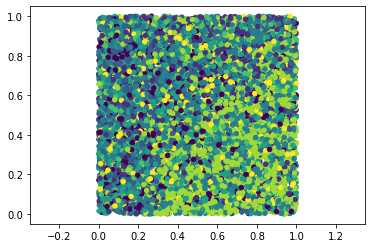

In [79]:
plt.scatter(X[:,0], X[:,1], c=z, s=20)
plt.axis('equal')
plt.show()

## 3. Learning

### 3.1. Train / test partition

In [80]:
# Inputs
X_train = Xe[:n_train, :]
X_test = Xe[n_train:, :]
# Clean labels
y_train = y[:n_train]
y_test = y[n_train:]
# Weak labels
z_train = z[:n_train]
z_test = z[n_train:]
# True posteriors
eta_train = posteriors[:n_train]
eta_test = posteriors[n_train:]


### 3.2. Model fitting

In this section we will test the behavior of a given weak loss for different virtual label matrices.

We train the model with the given dataset, and different types of virtual label models

In [81]:
DKL, ERR, MSE, DW = {}, {}, {}, {}

# Train all models
v_train, v_test = {}, {}
clf = {}
print(p)
for name, model in algorithms.items():
    print(f"{name}: Virtual labels: {model['vl']}, Loss: {model['params']['loss']}")

    vlm = model['vl']

    clf[name] = wl_classifier.WeakLogisticRegression(
        n_classes = WLM.c, optimizer=optim, params=model['params'], canonical_link=True)

    # Compute all virtual labels for training and testing
    if vlm == 'Supervised':
        v_train[name] = y_train
        v_test[name] = y_test
    else:
        v_train[name] = WLM.virtual_labels(z_train, vlm, p=p)
        v_test[name] = WLM.virtual_labels(z_test, vlm, p=p)  # <- Warning: maybe I should compute this from Y_train

    # Fit logistic regressioin model
    clf[name].fit(X_train, v_train[name])


    # Compute performance metrics
    # Errors
    ERR[name] = np.mean(clf[name].predict(X_test)!=y_test)
    # KL divergence
    DKL[name] = np.mean(KLdiv_from_weights(true_W, clf[name].W, X_test))
    # MSE
    f = clf[name].predict_proba(X_test)
    # square_errors = np.sum((eta_test - sparsemax(f))**2, axis=1)
    square_errors = np.sum((eta_test - f)**2, axis=1)
    MSE[name] = np.mean(square_errors)

    DW[name] = np.mean(np.abs(normalize_rows(true_W) -normalize_rows(clf[name].W)))

    

[0.07658241 0.09545703 0.09075242 0.23861856 0.13582772 0.06145644
 0.23440657 0.06689885]
M-pinv: Virtual labels: M-pinv, Loss: LBL
M-conv: Virtual labels: M-conv, Loss: LBL
M-opt: Virtual labels: M-opt, Loss: LBL
M-opt-conv: Virtual labels: M-opt-conv, Loss: LBL
S-LBL: Virtual labels: Supervised, Loss: LBL
S_CE: Virtual labels: Supervised, Loss: CE


Now we plot three standard performance metrics. The first two metrics evaluate the quality of the posterior probability map:

 * (DKL): KL divergence: this is the  metric optimimized by the cross entropy (loss 'CE')
 * (MSE): Mean Square error: optimized by the brier score (loss 'squareError')

[PENDING TASK]: Implementing the divergence measure optimized by the corrected loss

Also, we evaluate the classification performance through the error rate

MSE: [0.06211, 0.05171, 0.03676, 0.03676, 0.0097, 0.00182]
Average error rate: [0.156, 0.1492, 0.1415, 0.1415, 0.1308, 0.1323]
Total errors: [1560, 1492, 1415, 1415, 1308, 1323], out of 10000


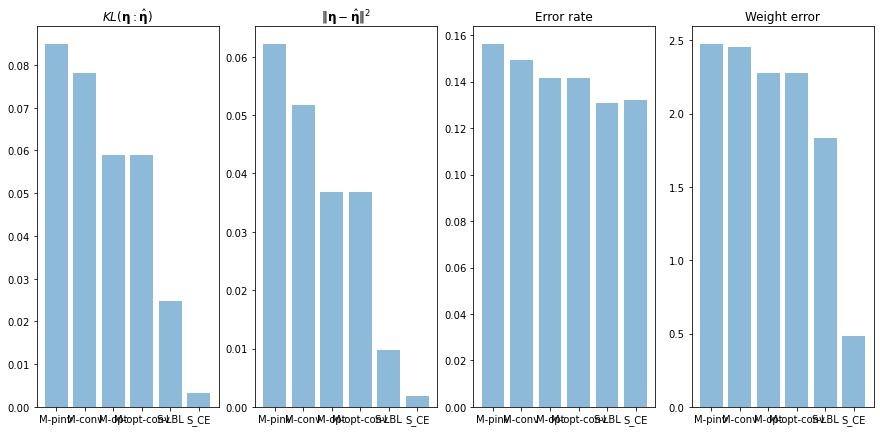

In [82]:
# print(f'KL divergences: {[float(round(1e5*x))/1e5 for x in DKL.values()]}')
print(f'MSE: {[float(round(1e5*x))/1e5 for x in MSE.values()]}')
print(f'Average error rate: {[float(round(1e5*x))/1e5 for x in ERR.values()]}')
print(f'Total errors: {[round(x*len(y_test)) for x in ERR.values()]}, out of {len(y_test)}')

alg_names = list(algorithms.keys())
plt.figure(figsize=[15, 7])
plt.subplot(141)
plt.bar(alg_names, DKL.values(), align='center', alpha=0.5, ecolor='black', capsize=10)
# Change the color of the minimum:
plt.title(r'$KL(\mathbf{\eta}: \hat{\mathbf{\eta}})$')
plt.subplot(142)
plt.bar(alg_names, MSE.values(), align='center', alpha=0.5, ecolor='black', capsize=10)
plt.title(r'$\Vert \mathbf{\eta} - \hat{\mathbf{\eta}}\Vert^2$')
plt.subplot(143)
plt.bar(alg_names, ERR.values(), align='center', alpha=0.5, ecolor='black', capsize=10)
plt.title(r'Error rate')
plt.subplot(144)
plt.bar(alg_names, DW.values(), align='center', alpha=0.5, ecolor='black', capsize=10)
plt.title(r'Weight error')
plt.show()

### 3.3. Training and test losses

In order to make sure that the learning algorithms are working properly, we compute all training losses over all classifiers.

In [15]:
# Compute losses
models_weak = [m for m in alg_names if m not in {'S-LBL', 'S_CE'}]
loss_train = {m: {} for m in models_weak}
loss_test = {m: {} for m in models_weak}
for m1 in models_weak:
    print(m1)
    m1_loss = algorithms[m1]['params']['loss']
    for m2 in models_weak:
        # Compute train and test losses
        if m1_loss == 'square':
            loss_train[m1][m2] = clf[m1].squareLoss(clf[m2].W, X_train, v_train[m1]) / n_train
            loss_test[m1][m2] = clf[m1].squareLoss(clf[m2].W, X_test, v_test[m1]) / n_test
        elif m1_loss == 'CE':
            loss_train[m1][m2] = clf[m1].logLoss(clf[m2].W, X_train, v_train[m1]) / n_train
            loss_test[m1][m2] = clf[m1].logLoss(clf[m2].W, X_test, v_test[m1]) / n_test
        elif m1_loss == 'LBL':
            loss_train[m1][m2] = clf[m1].LBLloss(clf[m2].W, X_train, v_train[m1]) / n_train
            loss_test[m1][m2] = clf[m1].LBLloss(clf[m2].W, X_test, v_test[m1]) / n_test
    print('Error rate for %s is : %0.3f'%(m1, ERR[m1]))
    print('KL divergence for %s is : %0.6f'%(m1, DKL[m1]))
    print('MSE for %s is : %0.6f'%(m1, MSE[m1]))
    print('-------------------')

M-pinv
Error rate for M-pinv is : 0.235
KL divergence for M-pinv is : 0.259598
MSE for M-pinv is : 0.153594
-------------------
M-conv
Error rate for M-conv is : 0.231
KL divergence for M-conv is : 0.245587
MSE for M-conv is : 0.144385
-------------------
M-opt
Error rate for M-opt is : 0.219
KL divergence for M-opt is : 0.215048
MSE for M-opt is : 0.127251
-------------------
M-opt-conv
Error rate for M-opt-conv is : 0.219
KL divergence for M-opt-conv is : 0.215047
MSE for M-opt-conv is : 0.127250
-------------------



In principle, the classifier trained with virtual labels Z should be the one minimizing the loss based on Z. In the figure below, the smaller error is shown in red. 

[0.37811240985637345, 0.3805822053177048, 0.38522229945405073, 0.3852229273454002]
[0.44671444574504576, 0.4442229579572848, 0.44713772538677177, 0.4471376325236391]
[0.4454781200096163, 0.4411110558248616, 0.43816182759603833, 0.43816182770234946]
[0.44548926162311764, 0.4411214223104918, 0.4381722803042806, 0.438172280197985]


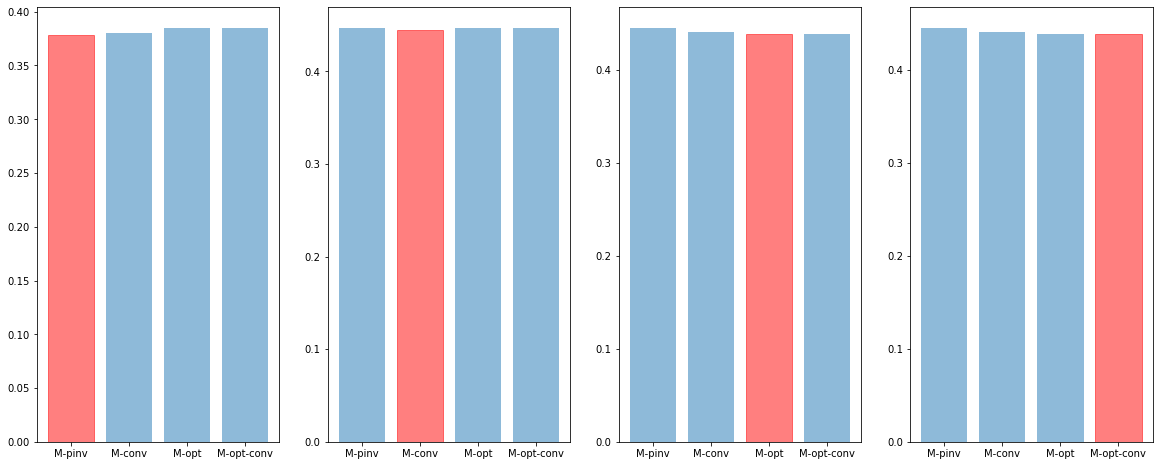

In [16]:
n_w = len(models_weak)

plt.figure(figsize=[20, 8])
for i, m1 in enumerate(models_weak):
    print(list(loss_train[m1].values()))
    plt.subplot(1, n_w, i+1)
    barplot = plt.bar(loss_train[m1].keys(), loss_train[m1].values(), align='center', alpha=0.5,
                      ecolor='black', capsize=10)
    # Change the color of the minimum:
    lmin = min(loss_train[m1].values())
    nmin = [n for n, m in enumerate(loss_train[m1]) if loss_train[m1][m] == lmin]
    for n in nmin:
        barplot[nmin[0]].set_color('r')
    # plt.title(f'Training {algorithms[m1]["params"]["loss"]} loss based on {m1}')

The figure below shows the test losses.

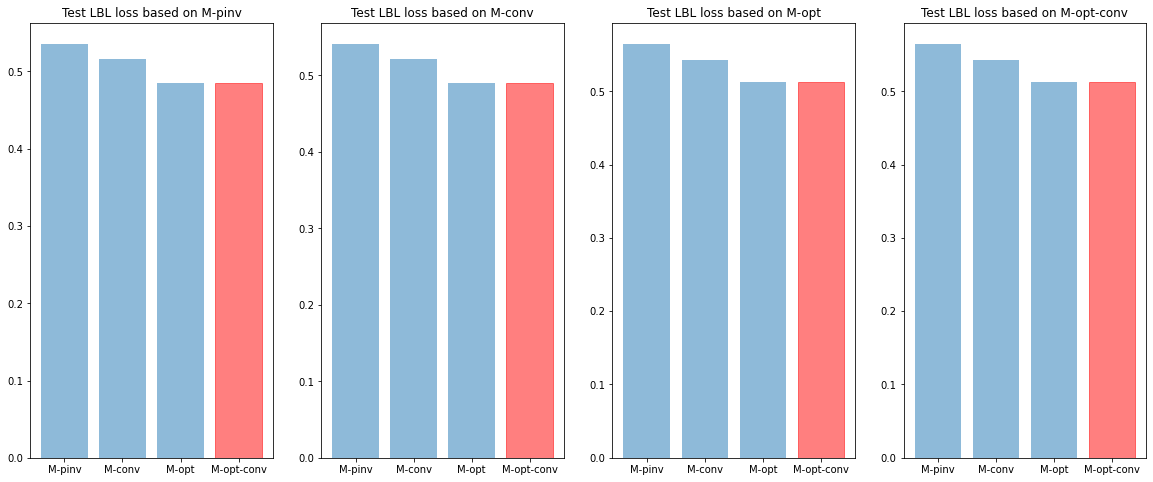

In [17]:
plt.figure(figsize=[20, 8])
for i, m1 in enumerate(models_weak):
    plt.subplot(1, n_w, i+1)
    barplot = plt.bar(loss_test[m1].keys(), loss_test[m1].values(), align='center', alpha=0.5,
                      ecolor='black', capsize=10)
    # Change the color of the minimum:
    lmin = min(loss_test[m1].values())
    nmin = [n for n, m in enumerate(loss_test[m1]) if loss_test[m1][m] == lmin]
    for n in nmin:
        barplot[nmin[0]].set_color('r')
    plt.title(f'Test {algorithms[m1]["params"]["loss"]} loss based on {m1}')
plt.show()

### 3.4. Average squared distance of the virtual labels

Since the virtual labels minimize the expected square distance to the true posterior, we test if it is the case over the test dataset.

The higher the differences between the square losses of optimized vs non-optimized models, the higher the potential advantages of the virtual label model.

First we show the expected MSE

Iteration 10000 out of 10000   

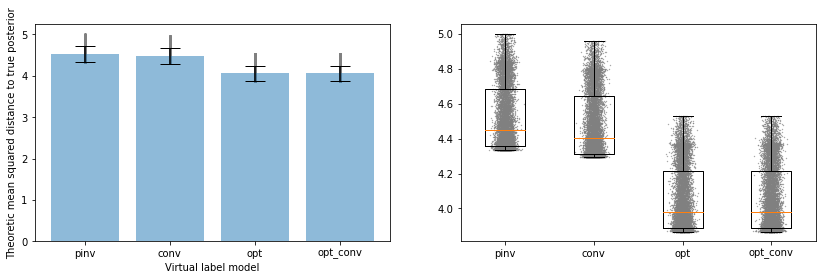

In [18]:
n_test = len(y_test)

tag_list = ['pinv', 'conv', 'opt', 'opt_conv']
mse = {tag: [] for tag in tag_list}
vse = {tag: [] for tag in tag_list}
alpha_eta = 0.9

eta_mean = np.mean(eta_test, axis=0, keepdims=True).T
# An estimate of the prior weak label probs based on the true posteriors
p_weak = M @ eta_mean
# A sample based estimate (the one used by the algorithms)
p_est = WLM.estimate_wl_priors(z_train)

# Compute different types of reconstruction matrices
Y_pinv = wlw.virtual_label_matrix(M, p=None, convex=False)
Y_conv = wlw.virtual_label_matrix(M, p=None, convex=True)
Y_opt = wlw.virtual_label_matrix(M, p=p_est, convex=False)
Y_opt_conv = wlw.virtual_label_matrix(M, p=p_est, convex=True)

Y2p_pinv = np.diag(Y_pinv.T @ Y_pinv) @ p_weak
Y2p_conv = np.diag(Y_conv.T @ Y_conv) @ p_weak
Y2p_opt = np.diag(Y_opt.T @ Y_opt) @ p_weak
Y2p_opt_conv = np.diag(Y_opt_conv.T @ Y_opt_conv) @ p_weak

p_test = eta_test @ M.T
eta2 = np.sum(eta_test**2, axis=1, keepdims=True)

for n in range(n_test):
    print(f"\rIteration {n+1} out of {n_test}   ", end="")
    mse['pinv'].append(Y2p_pinv - eta2[n])
    mse['conv'].append(Y2p_conv - eta2[n])
    mse['opt'].append(Y2p_opt - eta2[n])
    mse['opt_conv'].append(Y2p_opt_conv - eta2[n])
mse_mean2 = [np.mean(v) for k, v in mse.items()]
mse_std2 = [np.std(v) for k, v in mse.items()]

plt.figure(figsize=[14, 4])
plt.subplot(1, 2, 1)
plt.bar(mse.keys(), mse_mean2, yerr=mse_std2, align='center', alpha=0.5, ecolor='black', capsize=10)
for i, tag in enumerate(tag_list):
    plt.scatter([i]*n_test, mse[tag], color='gray', s=1, cmap='copper')
plt.xticks(tag_list, rotation='0')
plt.axis('tight')
plt.ylim((0, plt.ylim()[1]))
plt.xlabel('Virtual label model')
plt.ylabel('Theoretic mean squared distance to true posterior')

# Arrange data into matrix for boxplot
Z = np.array([np.array(v).T[0] for v in mse.values()]).T

plt.subplot(1, 2, 2)
for i, tag in enumerate(tag_list):
    xi = i + 1 + 0.05 * np.random.randn(n_test)
    plt.scatter(xi, mse[tag], s=0.1, color='gray')
plt.boxplot(Z, labels=mse.keys(), showfliers=False)
plt.show()

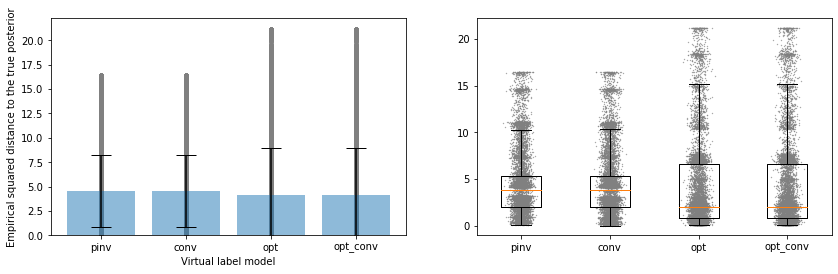

In [19]:
# Virtual-label-based square error
v_tst = WLM.virtual_labels_from_Y(z_test, Y_pinv)
vse['pinv'] = np.sum((eta_test-v_tst)**2, axis=1)
v_tst = WLM.virtual_labels_from_Y(z_test, Y_conv)
vse['conv'] = np.sum((eta_test-v_tst)**2, axis=1)
v_tst = WLM.virtual_labels_from_Y(z_test, Y_opt)
vse['opt'] = np.sum((eta_test-v_tst)**2, axis=1)
v_tst = WLM.virtual_labels_from_Y(z_test, Y_opt_conv)
vse['opt_conv'] = np.sum((eta_test-v_tst)**2, axis=1)
vse_mean = [np.mean(v) for k, v in vse.items()]
vse_std = [np.std(v) for k, v in vse.items()]

plt.figure(figsize=[14, 4])
plt.subplot(1, 2, 1)
plt.bar(vse.keys(), vse_mean, yerr=vse_std, align='center', alpha=0.5, ecolor='black', capsize=10)

for i, tag in enumerate(tag_list):
    plt.scatter([i]*v_tst.shape[0], vse[tag], color='gray', s=10, cmap='copper')
plt.xticks(tag_list, rotation='0')
plt.axis('tight')
plt.ylim((0, plt.ylim()[1]))
plt.xlabel('Virtual label model')
plt.ylabel('Empirical squared distance to the true posterior')

# Arrange data into matrix for boxplot
Z = np.array([np.array(v).T for v in vse.values()]).T

plt.subplot(1, 2, 2)
for i, tag in enumerate(tag_list):
    xi = i + 1 + 0.05 * np.random.randn(n_test)
    plt.scatter(xi, vse[tag], s=0.1, color='gray')
plt.boxplot(Z, labels=mse.keys(), showfliers=False)
plt.show()

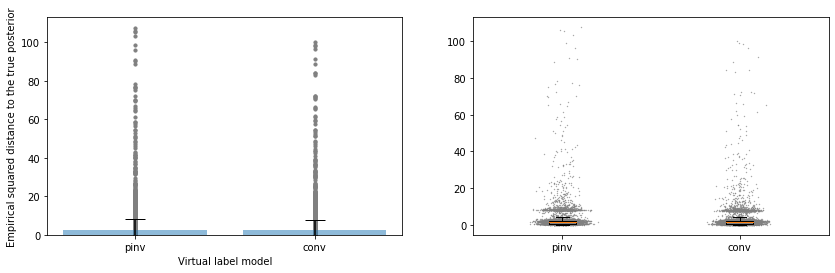

In [20]:
# Compute variance ratioo of optimized vs non-optimized virtual labels
# rse = {'pinv': vse['opt'] / vse['pinv'],
#        'conv': vse['opt_conv'] / vse['conv']}
rse = {'pinv': vse['pinv'] / vse['opt'],
       'conv': vse['conv'] / vse['opt_conv']}
rse_mean = [np.mean(v) for k, v in rse.items()]
rse_std = [np.std(v) for k, v in rse.items()]

plt.figure(figsize=[14, 4])
plt.subplot(1, 2, 1)
plt.bar(rse.keys(), rse_mean, yerr=rse_std, align='center', alpha=0.5, ecolor='black', capsize=10)

for i, tag in enumerate(rse):
    plt.scatter([i]*v_tst.shape[0], rse[tag], color='gray', s=10, cmap='copper')
plt.xticks(tag_list, rotation='0')
plt.axis('tight')
plt.ylim((0, plt.ylim()[1]))
plt.xlabel('Virtual label model')
plt.ylabel('Empirical squared distance to the true posterior')

# Arrange data into matrix for boxplot
Z = np.array([np.array(v).T for v in rse.values()]).T

plt.subplot(1, 2, 2)
for i, tag in enumerate(rse):
    xi = i + 1 + 0.05 * np.random.randn(n_test)
    plt.scatter(xi, rse[tag], s=0.1, color='gray')
plt.boxplot(Z, labels=rse.keys(), showfliers=False)
plt.show()


### 3.5. Scatter plots and maps over simplices.


(10000,)


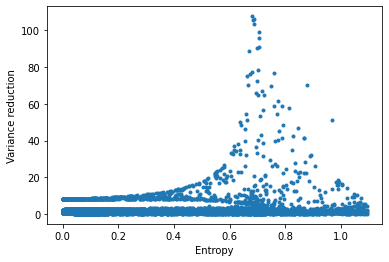

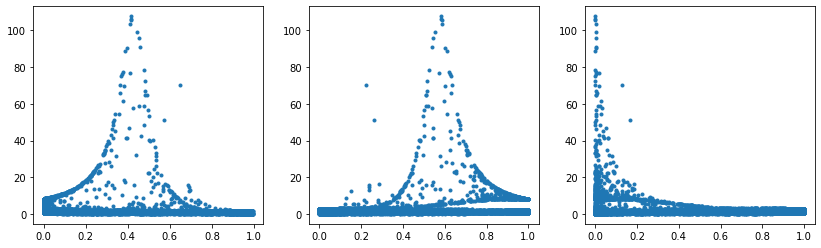

In [21]:
# Compute entropy
h = - np.sum(eta_test * np.log(eta_test), axis=1)
print(h.shape)
plt.plot(h, rse['pinv'], '.')
plt.xlabel('Entropy')
plt.ylabel('Variance reduction')
plt.show()

plt.figure(figsize=[14, 4])
for i in range(C):
    plt.subplot(1, C, i+1)
    plt.plot(eta_test[:, i], rse['pinv'], '.')
plt.show()

In [22]:
print(np.log(C))

1.0986122886681098


In [23]:
h = - np.sum(np.ones(C)/C * np.log(np.ones(C)/C))
print(h)

1.0986122886681096


(10000, 3)


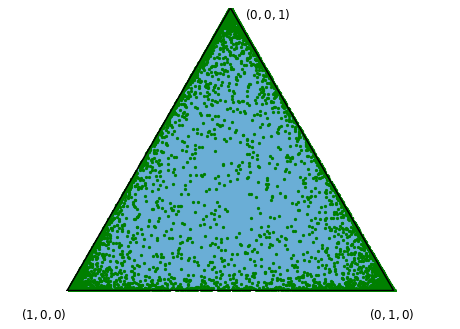

In [24]:
print(eta_test.shape)
if C==3:

    plot_simplices.scatter_probs(eta_test)
    plt.show()

In [25]:
print(np.max(np.sum(eta_test, axis=1)))

1.0000000000000009


(3, 8)
(8, 3)
square
KL
DD


/opt/anaconda3/lib/python3.8/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


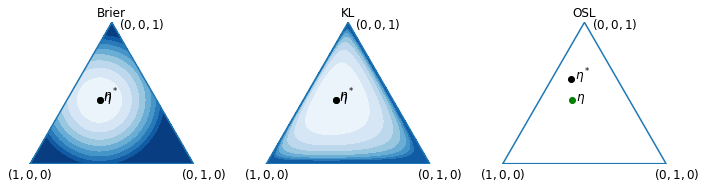

In [26]:
if C==3:
    # Parameters
    eta = np.array([0.35, 0.2, 0.45])       # Location of the minimum
    loss_names = ['square', 'KL', 'DD']    # 'square', 'log', 'l01' or 'DD'
    tags = ['Brier', 'KL', 'OSL']
    n_loss = len(loss_names)

    # Saturated values. These values have been tested experimentally:
    vmax_all = {'square': 1,
                'log': 1.6,
                'l01': 1,
                'DD': 1.2,
                'JS': 2,
                'L1loss': 2,
                'L1': 1.6,
                'L2': 1.6,
                'KL': 1.2,
                'JS': 1.6,
                'dH': 1.6,
                'He': 1.6}
    vmax = [vmax_all[name] for name in loss_names]

    R = Y_opt_conv
    print(R.shape)
    print(M.shape)
    plot_simplices.compute_draw_simplices(loss_names, tags, eta, vmax, R, M, N=300, fs=12)

    # plt.show(block=False)
    plt.show()